# PyTorch Framework

In this homework we will show the basic

<br><br>
*References*: <br>
<a href="https://pytorch.org/docs/stable/">PyTorch documentation</a> <br>


**Loading the dataset** <br>

*References*: <br>
<a href="https://pytorch.org/vision/stable/index.html">Torchvision</a><br>
<a href="https://github.com/zalandoresearch/fashion-mnist">FashionMNIST</a><br>
<a href="https://pytorch.org/docs/stable/data.html">DataLoader</a>

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torch

train_set = FashionMNIST("./data",
                         download=True,
                         train=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

test_set = FashionMNIST("./data",
                        download=True,
                        train=False,
                        transform=transforms.Compose([transforms.ToTensor()]))


BATCH_SIZE = 100

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Tensor size: (batch_size, n_channels, dim, dim)
torch.Size([100, 1, 28, 28])



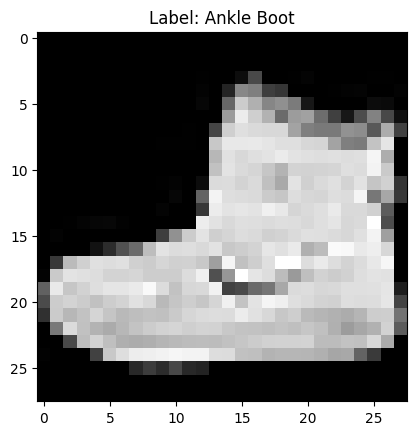

In [ ]:
import matplotlib.pyplot as plt

def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


a = next(iter(train_loader))
print("Tensor size: (batch_size, n_channels, dim, dim)")
print(a[0].size())
print()

image, label = next(iter(train_set))

plt.figure()
plt.title(f"Label: {output_label(label)}")
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Extrapolate the datasets dimensions.

IMAGE_CHANNELS = image.size(0)
IMAGE_DIM = image.size(1)
NUM_LABELS = 10

**Feed Forward Model**

*References*:<br>
<a href="https://pytorch.org/docs/stable/nn.html">torch.nn</a><br>
<a href="https://pytorch.org/docs/stable/generated/torch.Tensor.view.html">torch.view()</a>

In [ ]:
import torch.nn as nn

# Define custom Neural Network Module.
# MANDATORY to define define the __init__ method (the Python custructor) and the forward() pass method.
class FashionFF(nn.Module):

    # Class constructor. Here we define the layers of our network.
    def __init__(self, image_dim, image_channels, num_labels):
        super(FashionFF, self).__init__()

        # The input MUST be an array with size 784 (NOT a matrix 1x28x28)
        self.linear1 = nn.Linear(image_channels*image_dim*image_dim, 16)
        self.linear2 = nn.Linear(16, 40)
        self.linear3 = nn.Linear(40, 80)
        self.linear4 = nn.Linear(80, num_labels)
        self.dropout = nn.Dropout(0.25)

    # Forward pass. Here we define how the layers are concatenated.
    # We can use all type of operation (complex pytorch functions like torch.cat or simple +,-,*,/ operations).
    def forward(self, images):

        # IMPORTANT: remember the size: (batch_size, num_channels, dim, dim)
        # So we want to transform the 100 images 1x28x28 in 100 arrays with length 784.
        # The view() function perform a reshape over the Tensor.
        # With images.size(0), we tell the method to preserve the first dimension,
        # and with -1 we tell the method to inferr the second dimension from the others remained in the input tensor (and so 1x28x28 = 784)
        images = images.view(images.size(0), -1)

        x = self.linear1(images)
        x = self.linear2(self.dropout(x))
        x = self.linear3(self.dropout(x))
        x = self.linear4(self.dropout(x))

        return x

In [ ]:
class FashionCNN(nn.Module):

    def __init__(self, images_channels, num_labels):
        super(FashionCNN, self).__init__()

        # In the Sequential container we define a series of chained layer executed in order (like the Sequential keras block).
        # In this case we regroup all the operatorions for a Convolutional Block.
        # This is completely optional. You can stack layers upon layers as in Feed-Forward networks.

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=images_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # The Sequential container is quick to code (no forward pass definition required) and the code is clearer to read, interpret and modify.
        # But it has three major disadvantages:
        # 1) You cannot edit the forward pass;
        # 2) You cannot use useful function like "view()": you have to define a nn.Module that recreates the operation;
        # 3) There is less control. For instance, you cannot debug inside the container (i.e. if you have incorrectly entered the size of a layer).

        # As done for the FF network we flatten the matrix returned by the second Convolutional Block.
        # How we derive 64x6x6 ?
        # With the CNN theory of course, but a pratical way would be adding a print(out.shape) in our forward pass after the call to the second Sequential block.
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)

        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_labels)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

**Define Training Function**

*We define only a trining loop for both networks.* <br>
*This can be useful: less code to write.*

In [ ]:
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

def train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer, scaler, device):

    # Looping through epochs.
    for epoch in tqdm(range(num_epochs)):

        # Set the model in "train mode" (i.e. dropout layer active)
        model.train()

        ep_loss = 0
        for images, labels in train_loader:

            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()

            # To GPU (if available)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            ep_loss += loss.item()

            # Backpropagation
            scaler.scale(loss).backward()

            # Parameters update.
            scaler.step(optimizer)
            scaler.update()


        # Testing the model

        # Set the model in "test mode" (i.e. dropout layer deactivated)
        model.eval()

        test_labels = []
        predictions = []

        for images, labels in test_loader:
            images = images.to(device)

            # Disable gradient calculation to reduce memory consumption (we do not need gradient in prediction)
            with torch.no_grad():
                outputs = model(images)

            predictions += outputs.argmax(dim=-1).cpu().numpy().tolist()
            test_labels += labels.cpu().numpy().tolist()

        # Log Metrics.
        print(f"\tEpoch: {epoch+1}, Loss: {round(ep_loss/len(train_loader), 4)}, Accuracy: {round(accuracy_score(test_labels, predictions)*100, 2)}%")

    return model


**Define Hyperparameters and Training Tools** <br><br>

*Reference*: <br>
<a href="https://pytorch.org/docs/stable/nn.html#loss-functions">Loss Functions</a><br>
<a href="https://pytorch.org/docs/stable/optim.html">Optimizer</a><br>
<a href="https://pytorch.org/docs/stable/amp.html#gradient-scaling">Gradient Scaler</a>


In [ ]:
from  torch.optim import AdamW

# Define the torch device. REMEMBER to activate the GPU in the Runtime > Change type of Runtime settings.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = FashionFF(IMAGE_DIM, IMAGE_CHANNELS, NUM_LABELS).to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
scaler = GradScaler()

num_epochs = 10

# Lunch again train_model with tuned_ff to continue the training from the 11th epoch.
tuned_ff = train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer, scaler, device)

Device: cuda


 10%|█         | 1/10 [00:18<02:44, 18.27s/it]

	Epoch: 1, Loss: 0.8134, Accuracy: 80.55%


 20%|██        | 2/10 [00:27<01:41, 12.66s/it]

	Epoch: 2, Loss: 0.6084, Accuracy: 81.69%


 30%|███       | 3/10 [00:35<01:15, 10.73s/it]

	Epoch: 3, Loss: 0.5771, Accuracy: 82.59%


 40%|████      | 4/10 [00:43<00:58,  9.82s/it]

	Epoch: 4, Loss: 0.5613, Accuracy: 82.86%


 50%|█████     | 5/10 [00:52<00:47,  9.41s/it]

	Epoch: 5, Loss: 0.5436, Accuracy: 83.19%


 60%|██████    | 6/10 [01:01<00:36,  9.15s/it]

	Epoch: 6, Loss: 0.5353, Accuracy: 83.16%


 70%|███████   | 7/10 [01:09<00:26,  8.77s/it]

	Epoch: 7, Loss: 0.5289, Accuracy: 83.73%


 80%|████████  | 8/10 [01:17<00:17,  8.75s/it]

	Epoch: 8, Loss: 0.5251, Accuracy: 83.4%


 90%|█████████ | 9/10 [01:26<00:08,  8.78s/it]

	Epoch: 9, Loss: 0.5221, Accuracy: 83.65%


100%|██████████| 10/10 [01:34<00:00,  9.49s/it]

	Epoch: 10, Loss: 0.516, Accuracy: 83.62%


*Reusing the same code and changing only the model to be trained...*

In [ ]:
model = FashionCNN(IMAGE_CHANNELS, NUM_LABELS).to(device)

# Recreate the optimizer (with the new params) and the scaler rate (that was updated in the first training)
optimizer = AdamW(model.parameters(), lr=learning_rate)
scaler = GradScaler()

tuned_cnn = train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer, scaler, device)

 10%|█         | 1/10 [00:11<01:43, 11.48s/it]

	Epoch: 1, Loss: 0.4288, Accuracy: 86.07%


 20%|██        | 2/10 [00:22<01:29, 11.14s/it]

	Epoch: 2, Loss: 0.2919, Accuracy: 87.65%


 30%|███       | 3/10 [00:32<01:14, 10.66s/it]

	Epoch: 3, Loss: 0.2544, Accuracy: 88.25%


 40%|████      | 4/10 [00:42<01:03, 10.54s/it]

	Epoch: 4, Loss: 0.2322, Accuracy: 88.4%


 50%|█████     | 5/10 [00:52<00:51, 10.36s/it]

	Epoch: 5, Loss: 0.2124, Accuracy: 90.68%


 60%|██████    | 6/10 [01:03<00:41, 10.29s/it]

	Epoch: 6, Loss: 0.1957, Accuracy: 90.04%


 70%|███████   | 7/10 [01:12<00:30, 10.03s/it]

	Epoch: 7, Loss: 0.1802, Accuracy: 90.61%


 80%|████████  | 8/10 [01:22<00:20, 10.09s/it]

	Epoch: 8, Loss: 0.1697, Accuracy: 90.39%


 90%|█████████ | 9/10 [01:32<00:10, 10.07s/it]

	Epoch: 9, Loss: 0.1574, Accuracy: 89.91%


100%|██████████| 10/10 [01:43<00:00, 10.34s/it]

	Epoch: 10, Loss: 0.1503, Accuracy: 90.01%
